<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/jax/bayesian_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates the application of PGD, PQN, PMGD, SOUL, and VI to the Bayesian latent space network model from Hoff et al. (2002). 

# Latent space network model - Sampson Monks Data

First, we load the modules that we will need:

In [1]:
#@title Load modules.

# Install the wget package on Colab (if running the notebook locally,
# comment the following line out).
#!pip install wget

# OS and wget to load dataset.
import os
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform

# Numpy for computations.
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

key = random.PRNGKey(0)

# Pyplot for plots.
import matplotlib.pyplot as plt 

In [2]:
from load_monks import load_monks
from coinem.dataset import Dataset

# Load Sampson's monastery network
Y, labels, names = load_monks(dynamic=True, is_directed=False)
y=jnp.asarray(Y[0])

data = Dataset(y=y)

/Users/danieldodd/miniconda3/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [5]:
from coinem.dataset import Dataset
from coinem.model import AbstractModel
from jaxtyping import Array, Float
from dataclasses import dataclass

@dataclass
class MonksModel(AbstractModel):

    def log_prob(self, latent: Float[Array, "P D"], theta: Float[Array, "Q"], data: Dataset) -> Float[Array, ""]:
        
        z = latent

        dist = jnp.matmul(z,z.T)/jnp.linalg.norm(z,axis=1)
        #dist = jnp.sqrt(jnp.sum((z[None, :] - z[:, None])**2, -1))
        
        eta = theta - dist
        log_prior =  -jnp.sum(jnp.dot(z.T,z))  
        log_lik = jnp.sum(jnp.multiply(data.y.squeeze(), eta) - jnp.log1p(jnp.exp(eta)))
        return log_lik + log_prior



## Run the various algorithms and plot the latent representation

In [7]:
# Set approximation parameters:
h = 1e-2 # Step-size. 
K = 100  # Number of steps.
N = 10  # Number of particles.
D = y.shape[0]

# Initialize the latent positions using the random dot product graph latent representation
Lambda, U = jnp.linalg.eig(y)
x_latent = jnp.dot(U[:,:2],np.diag(np.sqrt(np.sort(np.abs(Lambda))[::-1][:2])))
x_latent = jnp.asarray(x_latent,dtype=float)


X0 = 0.01*random.normal(key,(N, D, 2)) + x_latent[None, :]

model = MonksModel()

/Users/danieldodd/miniconda3/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:1993: ComplexWarning: Casting complex values to real discards the imaginary part
  out_array: Array = lax_internal._convert_element_type(out, dtype, weak_type=weak_type)


In [14]:
from coinem.network_zoo import pgd, coin_svgd

th0 = jnp.array([[1.0]])  # Parameter estimate.

# Run algorithms:
X_pgd, th_pgd  = pgd(model, data, X0, th0, K)

X_coin, th_coin = coin_svgd(model, data, X0, th0, K)

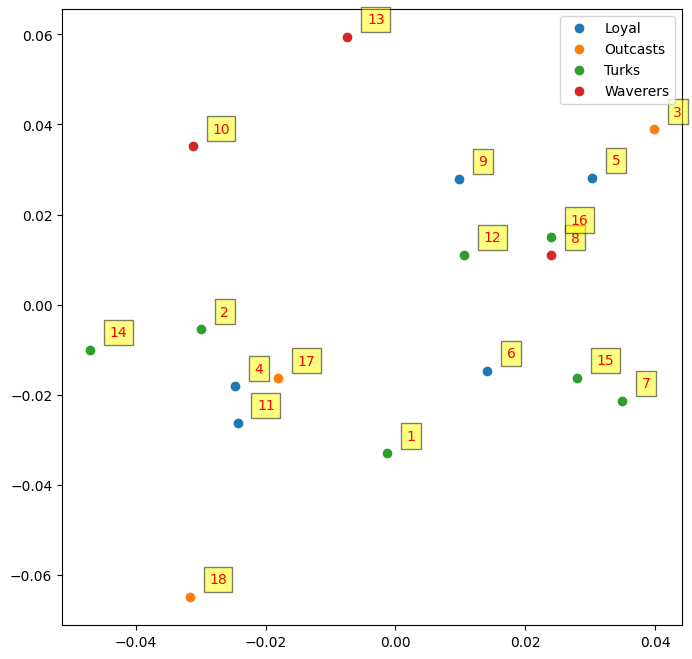

In [ ]:
import pandas as pd

avg_X_coin = jnp.mean(X_coin,axis=2)
avg_X_pgd = jnp.mean(X_pgd,axis=2)

names = ["John Bosco", "Gregory", "Basil", "Peter", "Bonaventure", "Berthold", "Mark", "Victor", "Ambrose", "Romauld", "Louis", "Winfrid", "Amand", "Hugh", "Boniface", "Albert", "Elias", "Simplicius"]
numbers = [str(a) for a in np.arange(1,19)]
group = ["Turks", "Turks", "Outcasts", "Loyal", "Loyal", "Loyal", "Turks", "Loyal", "Loyal", "Loyal", "Loyal", "Turks", "Outcasts", "Turks", "Turks", "Turks", "Outcasts", "Outcasts"]
waverers = ["Turks", "Turks", "Outcasts", "Loyal", "Loyal", "Loyal", "Turks", "Waverers", "Loyal", "Waverers", "Loyal", "Turks", "Waverers", "Turks", "Turks", "Turks", "Outcasts", "Outcasts"]

data = pd.DataFrame({"X": avg_X_pgd[:,0], "Y": avg_X_pgd[:,1], "Group": waverers})
groups = data.groupby("Group")
fig = plt.figure(figsize=(8,8), dpi= 100)
for name, group in groups:
    plt.plot(np.asarray(group["X"]), np.asarray(group["Y"]), marker="o", linestyle="", label=name)
plt.legend()
#plt.scatter(avg_X_pgd[:,0],avg_X_pgd[:,1])
for i in range(D):
    plt.text(x=avg_X_pgd[i,0]+0.003,y=avg_X_pgd[i,1]+0.003,s=numbers[i],fontdict=dict(color='red',size=10),bbox=dict(facecolor='yellow',alpha=0.5))

# Plot the results from the random dot product graph

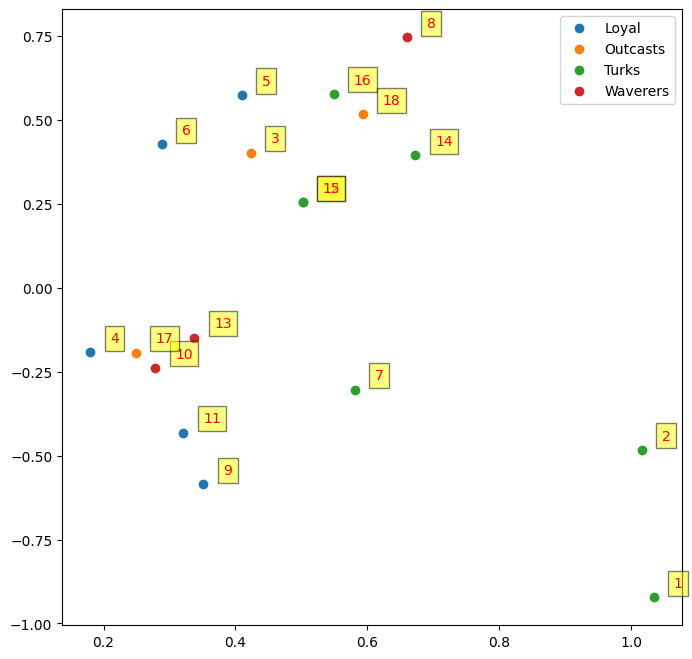

In [ ]:
import pandas as pd


names = ["John Bosco", "Gregory", "Basil", "Peter", "Bonaventure", "Berthold", "Mark", "Victor", "Ambrose", "Romauld", "Louis", "Winfrid", "Amand", "Hugh", "Boniface", "Albert", "Elias", "Simplicius"]
numbers = [str(a) for a in np.arange(1,19)]
group = ["Turks", "Turks", "Outcasts", "Loyal", "Loyal", "Loyal", "Turks", "Loyal", "Loyal", "Loyal", "Loyal", "Turks", "Outcasts", "Turks", "Turks", "Turks", "Outcasts", "Outcasts"]
waverers = ["Turks", "Turks", "Outcasts", "Loyal", "Loyal", "Loyal", "Turks", "Waverers", "Loyal", "Waverers", "Loyal", "Turks", "Waverers", "Turks", "Turks", "Turks", "Outcasts", "Outcasts"]

data = pd.DataFrame({"X": x_latent[:,0], "Y": x_latent[:,1], "Group": waverers})
groups = data.groupby("Group")
fig = plt.figure(figsize=(8,8), dpi= 100)
for name, group in groups:
    plt.plot(np.asarray(group["X"]), np.asarray(group["Y"]), marker="o", linestyle="", label=name)
plt.legend()
#plt.scatter(avg_X_pgd[:,0],avg_X_pgd[:,1])
for i in range(D):
    plt.text(x=x_latent[i,0]+0.03,y=x_latent[i,1]+0.03,s=numbers[i],fontdict=dict(color='red',size=10),bbox=dict(facecolor='yellow',alpha=0.5))

And plot the parameter estimates as a function of k:

In [13]:
th_pgd.shape

(100, 10, 18, 2)

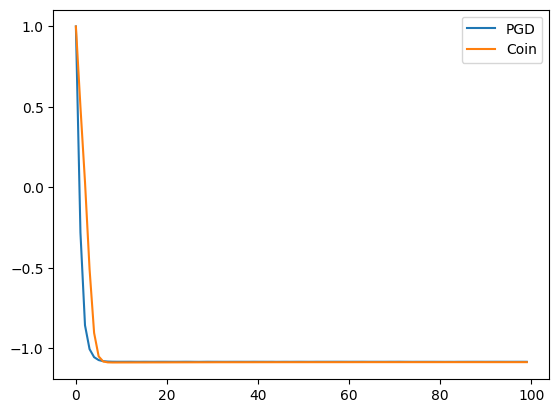

In [16]:
#plt.plot(th_vi, label='VI')
plt.plot(th_pgd.squeeze(), label='PGD')
#plt.xlim([-K/100, K])
#plt.plot(th_pqn, label='PQN')
#plt.plot(th_pmgd, label='PMGD')
#plt.plot(th_soul, label='SOUL')
plt.plot(th_coin.squeeze(), label='Coin')
plt.legend(loc='upper right')

The estimates produced by all five algorithms converge to the same limit after similar transients. To observe more significant differences between the algorithms' outputs, we examine the posterior approximations they return...